### A Content Based Image Retrieval Pipeline

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.metrics.pairwise import euclidean_distances,cosine_distances
import collections

### Import Dataset

In [2]:
def get_name(filename):
    i = filename.rfind('/')
    j = filename.rfind('.')
    return filename[i+1:j]

In [3]:
def get_image(filename):
    return cv2.resize(cv2.cvtColor(cv2.imread(filename),
                                   cv2.COLOR_BGR2GRAY).astype('uint8'),
                      (256,256))

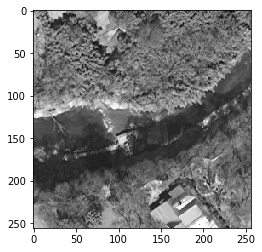

In [4]:
file_directory = "./Smaller_Dataset/**/*.tif"

all_files = glob.glob(file_directory)

all_images = {get_name(file):get_image(file) for file in all_files}
plt.imshow(all_images['river03'],cmap='gray')


In [5]:
# This function extracts all the true similar images, or in other words the ground 
# truth for a particular query. In the case of this dataset it is the images of the
# same class

def get_true_similar(query):
    base_name = ''.join([char for char in query if not char.isdigit()])
    true_similar = {file:image for file, image in all_images.items() if base_name in file}
#     for file, image in all_images.items():
#         if base_name in file:
#             true_similar.append((file, image))
    
    return true_similar

Similar images to image 'river03' are as follows


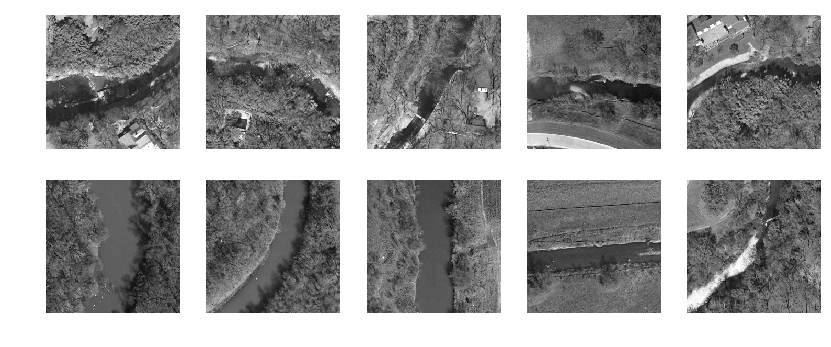

In [6]:
# Testing the get_true_similar function        
true_rivers = [image for key, image in get_true_similar('river03').items()]
# There will always be 10 similar images to a particular query image
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4), dpi=100)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(true_rivers[i], cmap='gray')
    ax.grid(False)
    ax.axis('off')
print("Similar images to image 'river03' are as follows")

### Feature Extraction

In [21]:
def split_image(image):
    len
def local_histogram(image, reduce_factor = 2):
    split_image(image)

local_histogram(all_images['river03'])

(256, 256)


In [7]:
def get_features(all_images,descriptor='hist'):
    all_features = {}
    if descriptor=='hist':
        all_features = {filename:cv2.calcHist(img,[0],None,[256],[0, 256]).flatten() for (filename,img) in all_images.items()}
    elif descriptor=='sift':
        sift = cv2.xfeatures2d.SIFT_create()
        all_features = {filename:sift.detectAndCompute(img,None)[1] for (filename,img) in all_images.items()}
    elif descriptor=='hog':
        hog = cv2.HOGDescriptor()
        all_features = {filename:hog.compute(img).flatten() for (filename,img) in all_images.items()}
    else:
        print("Incorrect descriptor")
    return all_features

In [8]:
# For any given image the feature vector should be the same shape
features_db = get_features(all_images)
print(features_db['river03'].shape)
print(features_db['beach01'].shape)

(256,)
(256,)


In [23]:
# Test if HOG features work or not
features_hog = get_features(all_images, descriptor='hog')
print(features_hog['river03'].shape)
print(features_hog['beach03'].shape)
for k, v in features_hog.items():
    if(v.shape[0] != 1606500):
        print(k, ":", v.shape)

(1606500,)
(1606500,)


### Similarity Computation

In [12]:
def compute_similarity(query_img_fv,features_db,dist='cosine'):
    all_similarity = None
    if dist == 'cosine':
        all_similarity = {filename:cosine_distances(query_img_fv.reshape(1, -1),img_fv.reshape(1, -1))[0,0] for (filename,img_fv) in features_db.items()}
    elif dist == 'euclidean':
        all_similarity = {filename:euclidean_distances(query_img_fv.reshape(1, -1),img_fv.reshape(1, -1))[0,0] for (filename,img_fv) in features_db.items()}
    
    #Sort Results
    sorted_all_similarity = sorted(all_similarity.items(), key=lambda kv: kv[1])
#     len(sorted_all_similarity)
    sorted_all_similarity = collections.OrderedDict(sorted_all_similarity)
    return sorted_all_similarity

Retrieved images to image 'river03' are as follows


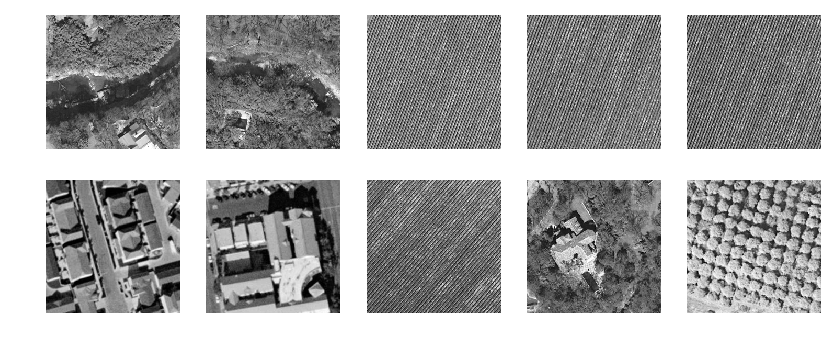

In [13]:
# Testing the Compute Similarity Function
similarity_scores = compute_similarity(features_db['river03'],features_db, dist='euclidean')

top_ten_similar = []
for k, v in similarity_scores.items():
    top_ten_similar.append(all_images[k])
    
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4), dpi=100)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(top_ten_similar[i], cmap='gray')
    ax.grid(False)
    ax.axis('off')
    
print("Retrieved images to image 'river03' are as follows")

Retrieved images to image 'river03' are as follows


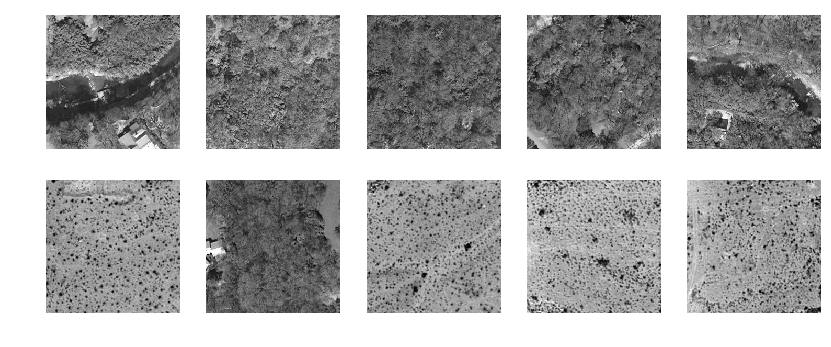

In [25]:
# Testing the Compute Similarity Function
similarity_scores = compute_similarity(features_hog['river03'],features_hog, dist='euclidean')

top_ten_similar = []
for k, v in similarity_scores.items():
    top_ten_similar.append(all_images[k])
    
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4), dpi=100)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(top_ten_similar[i], cmap='gray')
    ax.grid(False)
    ax.axis('off')
    
print("Retrieved images to image 'river03' are as follows")

### Evaluation

##### Average Normalized Mean Retrieval Rank

In [30]:
def K(gt):
    return float(2*len(gt))

def MeanRank(ground_truth, retrieved):
    total_rank = 0.0
    gt_size = len(ground_truth)
    k = K(ground_truth)
    for image in ground_truth:
        position = retrieved.index(image)
        if(position > k):
            total_rank += 1.25*k
        else:
            total_rank += float(position)
    
    return total_rank/gt_size
        
def NMRR(ground_truth, retrieved):
    gt_size = float(len(ground_truth))
    mrr = MeanRank(ground_truth, retrieved) - 0.5*(1 + gt_size)
    if(mrr < 0):
        mrr = 0
    nmrr = mrr / (1.25*K(ground_truth) - 0.5*(1 + gt_size))
    
    return nmrr

# All helper functions directly take lists, so they need to be converted from
# dictionaries to lists that only contain the names of the images
def ANMRR(query_list, features_db):
    total_nmrr = 0.0
    for query in query_list:
        ground_truth = get_true_similar(query)
        gt_list = [k for k, v in ground_truth.items()]
        retrieved_dict = compute_similarity(features_db[query], features_db)
        retrieved_list = [k for k, v in retrieved_dict.items()]
        nmrr = NMRR(gt_list, retrieved_list)
        total_nmrr += nmrr
    return total_nmrr/float(len(query_list))
        
    
query_list = ['river03', 'beach03', 'airplane04']
anmrr = ANMRR(query_list, features_db)
anmrr

0.582905982905983

##### Mean Average Precision

In [28]:
def PatK(ground_truth, retrieved, k):
    true_positives = 0.0
    for i in range(k):
        if retrieved[i] in ground_truth:
            true_positives += 1
            if i == (k-1):
                precision = true_positives / float(k)
                return precision
        elif i == (k-1):
            return 0.0

def AP(ground_truth, retrieved):
    gt_size = float(len(ground_truth))
    retrieved_size = len(retrieved)
    
    total_precision = 0.0
    
    for i in range(1, retrieved_size):
        precision_at_k = PatK(ground_truth, retrieved, i)
        total_precision += precision_at_k
    return (total_precision/gt_size)
    
# All helper functions directly take lists, so they need to be converted from
# dictionaries to lists that only contain the names of the images
def MAP(query_list, features_db):
    total_AP = 0.0
    for query in query_list:
        ground_truth = get_true_similar(query)
        gt_list = [k for k, v in ground_truth.items()]
        retrieved_dict = compute_similarity(features_db[query], features_db)
        retrieved_list = [k for k, v in retrieved_dict.items()]
        average_precision = AP(ground_truth, retrieved_list)
        total_AP += average_precision
    return total_AP / float(len(query_list))
        
query_list = ['river03', 'beach03', 'airplane04']
mean_average_precision = MAP(query_list, features_db)
mean_average_precision

0.3155279749130376

In [31]:
# Testing to see if Average Precision is working by altering the retrieved images
# Such that the ground_truth images are all on the top
def compute_fake_similarity(query_img_fv,features_db,dist='cosine'):
    all_similarity = None
    if dist == 'cosine':
        all_similarity = {filename:cosine_distances(query_img_fv.reshape(1, -1),img_fv.reshape(1, -1))[0,0] for (filename,img_fv) in features_db.items()}
    elif dist == 'euclidean':
        all_similarity = {filename:euclidean_distances(query_img_fv.reshape(1, -1),img_fv.reshape(1, -1))[0,0] for (filename,img_fv) in features_db.items()}
    
    #Sort Results
    all_rivers = ['river0'+str(i) for i in range(10)]
    for river in all_rivers:
        all_similarity[river] = 0.0

    sorted_all_similarity = sorted(all_similarity.items(), key=lambda kv: kv[1])
#     len(sorted_all_similarity)
    sorted_all_similarity = collections.OrderedDict(sorted_all_similarity)
    return sorted_all_similarity

def test_perfect():
    ground_truth = get_true_similar('river03')
    gt_list = [k for k, v in ground_truth.items()]
    retrieved_dict = compute_fake_similarity(features_db['river03'], features_db)
    retrieved_list = [k for k, v in retrieved_dict.items()]
    ap = AP(ground_truth, retrieved_list)
    nmrr = NMRR(ground_truth, retrieved_list)
    print("Average Precision is:", ap)
    print("NMRR is:", nmrr)

test_perfect()

Average Precision is: 1.0
NMRR is: 0.0


### Testing

In [18]:
def run_all(query_list, file_directory, descriptor='hist', similarity='cosine'):
    all_files = glob.glob(file_directory)
    all_images = {get_name(file):get_image(file) for file in all_files}

    features = get_features(all_images, descriptor)
    mean_average_precision = MAP(query_list, features)
    anmrr = ANMRR(query_list, features)
    print("Mean Average Precision is:", mean_average_precision)
    print("ANMRR is:", anmrr)


In [19]:
query_list = ['river03', 'beach03', 'airplane04']
file_directory = "./Smaller_Dataset/**/*.tif"
run_all(query_list, file_directory)

Mean Average Precision is: 0.3155279749130376
ANMRR is: 0.582905982905983


In [20]:
run_all(query_list, file_directory, descriptor='hog')

Mean Average Precision is: 0.2129695212963668
ANMRR is: 0.776068376068376
